<a href="https://colab.research.google.com/github/paolofesta/prove/blob/master/TESI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import tweepy

In [ ]:
# VARIABILI CREATE CON LE CREDENZIALI PER ACCEDERE ALLE API
ACCESS_TOKEN = '1500753981525659655-2OYENj2RBJS753zwIZ9a9zQukiSHY5'
ACCESS_SECRET = 'M1naDc08ZQuWYX7yZV4hRZ8IwH0J5uiraPXNzTe6Py2TL'
CONSUMER_KEY = 'yOKa2wpMnubBCq6pV3XLD8lRL'
CONSUMER_SECRET = 'pDyuUu4ssKWS4PHF4wN2lZ7RjdYQe1yLjBbK745o3vdOoxgtUN'

In [ ]:
# SETUP ACCESSO API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth, wait_on_rate_limit=True ,wait_on_rate_limit_notify=True)
    return api
    
api = connect_to_twitter_OAuth()

In [ ]:
def limit_handled(cursor):
  while True:
    try:
      yield cursor.next()
    except StopIteration:
      return
    except tweepy.RateLimitError:
        time.sleep(15*60)

In [ ]:
pp1=limit_handled(tweepy.Cursor(api.search,q= '@CislNazionale',tweet_mode='extended').items(5000)) 
pp1

In [ ]:

def extract_tweet_attributes(tweet_object):
    # create empty list
    tweet_list =[]
    # loop through tweet objects
    for tweet in tweet_object:
        tweet_id = tweet.id # unique integer identifier for tweet
        language= tweet.lang 
        name= tweet.user.name     
        location= tweet.user.location
        
        follower_count= tweet.user.followers_count
        verified= tweet.user.verified
        text = tweet.full_text # utf-8 text of tweet
        favorite_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        created_at = tweet.created_at # utc time tweet created
        source = tweet.source # utility used to post tweet
       
       
        # append attributes to list
        tweet_list.append({'tweet_id':tweet_id,
                           'language':language,
                          'text':text,
                           'name':name,
                           'location':location,
                           
                          'follower_count':follower_count,
                           'verified': verified,
                          'favorite_count':favorite_count,
                          'retweet_count':retweet_count,
                          'created_at':created_at, 
                          'source':source, 
                          })

    # create dataframe   
    df1 = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'text',
                                           'language',
                                           'name',
                                          
                                           'follower_count',
                                           'verified',
                                           'location',    
                                           'favorite_count',
                                           'retweet_count',
                                           'created_at',
                                           'source',
                                           ])
    return df1


df1 = extract_tweet_attributes(pp1)


In [ ]:
df1['name']=df1.loc[df1['name']!='CISL Nazionale']

In [ ]:
df1['sigla']='CISL'

In [ ]:
df1.to_csv(r'cisl_data',index=False)

In [ ]:
#processo ripetuto anche per cgil e uil per ottenere:
cisl_data=pd.read_csv(r'/content/cisl_data')
cgil_data=pd.read_csv(r'/content/cgil_data')
uil_data=pd.read_csv(r'/content/uil_data')


In [ ]:
data=pd.concat(cisl_data,cgil_data,uil_data)

In [ ]:
data=pd.read_csv(r'/content/data')


In [89]:
import re
import gensim
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'


In [ ]:
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

In [ ]:
def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet


In [ ]:
def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

In [ ]:
def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

In [ ]:
regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
def remove_em(tweet):
    tweet = re.sub(regex_pattern,'',tweet) #replaces pattern with ''
    return tweet


In [ ]:
def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = remove_em(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

In [ ]:
df1=pd.read_csv('/content/data',usecols=['text']) 
df1['tweet']=df1['text']
df2=df1.drop('text',axis=1)
df2

In [ ]:
def clean_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['cleaned'] = df.tweet.apply(basic_clean)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [ ]:
df3=clean_tweets(df2)
df3 #non faccio tokenizzazione e lemmatizzazione perchè FEEL-IT funziona con le frasi di senso compiuto

## Citation

Please use the following bibtex entry if you use this model in your project:

```
@inproceedings{bianchi2021feel,
    title = {{"FEEL-IT: Emotion and Sentiment Classification for the Italian Language"}},
    author = "Bianchi, Federico and Nozza, Debora and Hovy, Dirk",
    booktitle = "Proceedings of the 11th Workshop on Computational Approaches to Subjectivity, Sentiment and Social Media Analysis",
    year = "2021",
    publisher = "Association for Computational Linguistics",
}
```

In [ ]:
pip install feel-it

In [ ]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()

In [ ]:
dfcleaned=df3.drop('tweet',axis=1).astype('str')


In [ ]:
cleanedstring=pd.Series(dfcleaned['cleaned'].astype('string'))
cleanedstring.dtype

string[python]

In [ ]:
def stringToList(string):
  listRes = list(string.split(""))
  return listRes

In [ ]:
cleanedlist=cleanedstring.tolist()
cleanedlist

In [ ]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()
from feel_it import SentimentClassifier
sentiment_classifier = SentimentClassifier()

In [ ]:
sentimenti=sentiment_classifier.predict(cleanedlist)

In [ ]:
emozioni=emotion_classifier.predict(cleanedlist)

In [ ]:
data['sentiment']=sentimenti
data['emotion']=emozioni
data['cleaned_text']=cleanedlist

In [ ]:
data=data.loc[data['language']=='it'].drop('text',axis=1)
data

In [ ]:
datasent=data
datasent.to_csv(r'datasent',index=False)

In [ ]:
datasentcisl=datasent.loc[datasent['sigla']=='CISL']
datasentcisl.to_csv(r'datasentcisl',index=False)

In [ ]:
datasentcgil=datasent.loc[datasent['sigla']=='CGIL']
datasentcgil.to_csv(r'datasentcgil',index=False)

In [ ]:
datasentuil=datasent.loc[datasent['sigla']=='UIL']
datasentuil.to_csv(r'datasentuil',index=False)

In [98]:
datasent=pd.read_csv('/content/datasent')

In [109]:
dataword=datasent


In [110]:
dneg=dataword.loc[dataword['sentiment']=='negative']
dpos=dataword.loc[dataword['sentiment']=='positive']



In [111]:
words=pd.Series(dneg['cleaned_text']).astype('string').str.cat(sep=' ')

In [112]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['il','la','di','con','su','per','tra','fra','una','nel','dopo','alla','della','sono','dalla','al','un','non','più','dell','ma','dei','gli','lo','sul','da','ha','si','nei','le','delle','ai','solo','ad','siete','abbiamo','ora','oggi','che','maggio','nella','ed','come','del','questo','fa','anche','anni','alle','degli','dare','xix','tutto','poteva','notizia','se','serve','nuovo','questa','altre']) #adding our own stopwords

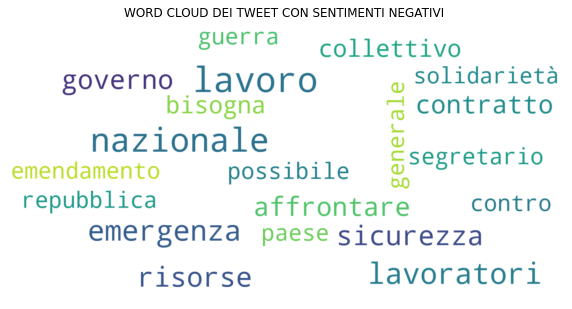

In [158]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET CON SENTIMENTI NEGATIVI ')
print()   

In [156]:
words1=pd.Series(dpos['cleaned_text']).astype('string').str.cat(sep=' ')

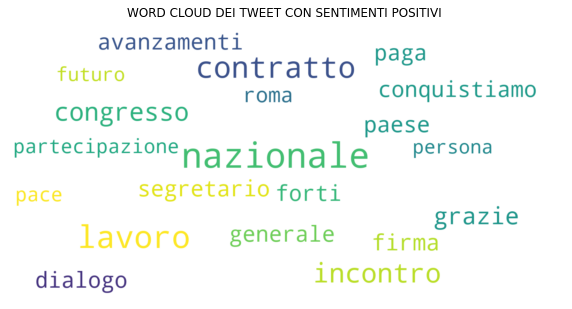

In [157]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(words1)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET CON SENTIMENTI POSITIVI ')   
print()

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter

In [ ]:
#datasent.count()#=6443
#datasent.loc[datasent['sentiment']=='negative'].count()#=4010
#datasent.loc[datasent['sentiment']=='positive'].count()#=2429

In [93]:
c={'percent':[(4010/6443)*100,(2429/6443)*100],'sentiment':['negative','positive']}
df=pd.DataFrame(c)
df['percent']=df['percent'].astype('int')

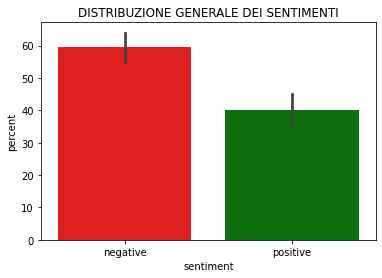

In [154]:

sns.barplot(data=df,x='sentiment',y='percent',palette=['r','g']).set_title('DISTRIBUZIONE GENERALE DEI SENTIMENTI') 
print()

In [ ]:
#datasent.loc[(datasent['sigla']=='CISL')].count()#=4492
#datasent.loc[(datasent['sigla']=='CISL') & (datasent['sentiment']=='negative')].count()#=2470
#datasent.loc[(datasent['sigla']=='CISL') & (datasent['sentiment']=='positive')].count()#=2022
#datasent.loc[(datasent['sigla']=='CGIL')].count()#=1438
#datasent.loc[(datasent['sigla']=='CGIL') & (datasent['sentiment']=='negative')].count()#=1146
#datasent.loc[(datasent['sigla']=='CGIL') & (datasent['sentiment']=='positive')].count()#=292
#datasent.loc[(datasent['sigla']=='UIL')].count()#=513
#datasent.loc[(datasent['sigla']=='UIL') & (datasent['sentiment']=='negative')].count()#=398
#datasent.loc[(datasent['sigla']=='UIL') & (datasent['sentiment']=='positive')].count()#=115

In [95]:
d={'percent':[(2470/4492)*100,(2022/4492)*100,(1146/1438)*100,(292/1438)*100,(398/513)*100,(115/513)*100],'sentiment':['negative','positive','negative','positive','negative','positive'],'sigla':['CISL','CISL','CGIL','CGIL','UIL','UIL']}
df1=pd.DataFrame(data=d)
df1['percent']=df1['percent'].astype('int')



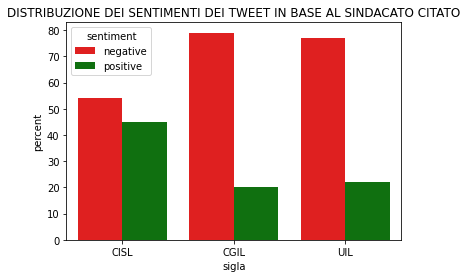

In [151]:
sns.barplot(data=df1,x='sigla',y='percent',hue='sentiment',palette=['r','g']).set_title('DISTRIBUZIONE DEI SENTIMENTI DEI TWEET IN BASE AL SINDACATO CITATO') 
print()

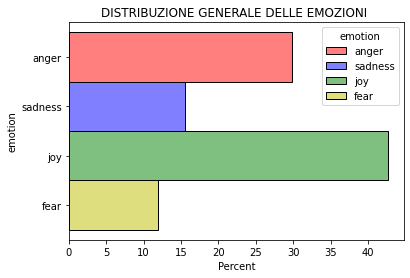

In [150]:
sns.histplot(datasent,y='emotion',stat='percent',hue='emotion',palette=['r','b','g','y']).set_title('DISTRIBUZIONE GENERALE DELLE EMOZIONI ') 
print()

QUESTE SONO LE OPINIONI GENERALI, MA CHI LE ESPRIME?\
come cambiano tra sezioni regionali/provinciali dei sindacati e altri utenti?\
quanti follower ha chi scrive? quale distribuzione di utenti in base al numero di follower? come cambiano le opinioni tra grandi e piccoli utenti?\
come cambiano le opinioni in base a età,posizione politica,posizione nel mdl, zona geografica mediante l'osservazione 'manuale' di un campione di utenti?

In [4]:
def low_name(tweet):
  
    tweet = tweet.lower()  # lower case
    
    return tweet

In [5]:
def low_df(df):
   

    df['lower'] = df.tweet.apply(low_name)
    num_tweets = len(df)
    
    return df

In [ ]:
datan=pd.read_csv('/content/datasent',usecols=['name']) 
datan['tweet']=datan['name']
datanext=datan.drop('name',axis=1)
datanext

In [ ]:
datalow=low_df(datanext).drop('tweet',axis=1)
datalow

In [ ]:
data_low_names=pd.read_csv('/content/datasent').drop('name',axis=1)
data_low_names['low_name']=datalow
data_low_names

In [ ]:
datasent_associati=data_low_names.loc[(data_low_names['low_name'].str.contains('uil'))|(data_low_names['low_name'].str.contains('cisl'))|(data_low_names['low_name'].str.contains('cgil'))]
datasent_associati['associati']='SI'

In [ ]:
datasent_nonassociati=data_low_names[~((data_low_names['low_name'].str.contains('uil'))|(data_low_names['low_name'].str.contains('cisl'))|(data_low_names['low_name'].str.contains('cgil')))]
datasent_nonassociati['associati']='NO'


In [11]:
data=pd.concat([datasent_associati,datasent_nonassociati])

wordcloud affiliati e non

In [12]:
wordsa=pd.Series(datasent_associati['cleaned_text']).astype('string').str.cat(sep=' ')

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['il','la','di','con','su','per','tra','fra','una','nel','dopo','alla','della','sono','dalla','al','un','non','più','dell','ma','dei','gli','lo','sul','da','ha','si','nei','le','delle','ai','solo','ad','siete','abbiamo','ora','oggi','che','maggio','nella','ed','come','del','questo','fa','anche','anni','alle','degli','dare','xix','tutto','poteva','notizia','se','serve','nuovo','questa','altre']) #adding our own stopwords

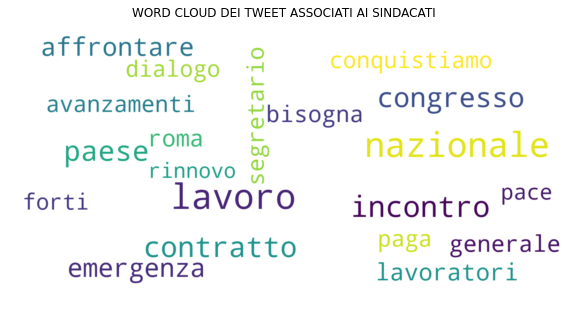

In [147]:
#prima bozza PAROLE TWEET AFFILIATI
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(wordsa)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET ASSOCIATI AI SINDACATI ')   
print()


In [15]:
wordsb=pd.Series(datasent_nonassociati['cleaned_text']).astype('string').str.cat(sep=' ')

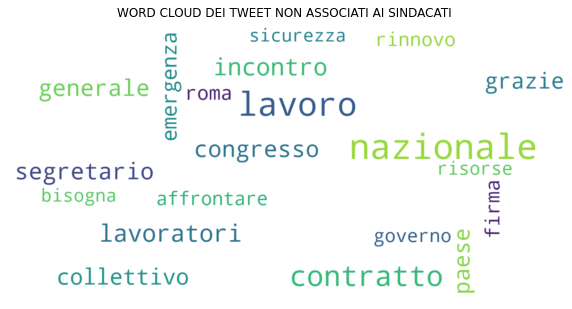

In [148]:

wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(wordsb)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.title('WORD CLOUD DEI TWEET NON ASSOCIATI AI SINDACATI ')   
print()

BOH

In [24]:
#data.loc[(data['associati']=='SI')].count()#=1249
#data.loc[(data['associati']=='SI') & (data['sentiment']=='negative')].count()#=687
#data.loc[(data['associati']=='SI') & (data['sentiment']=='positive')].count()#=562
#data.loc[(data['associati']=='NO')].count()#=5194
#data.loc[(data['associati']=='NO') & (data['sentiment']=='negative')].count()#=3327
#data.loc[(data['associati']=='NO') & (data['sentiment']=='positive')].count()#=1867


In [122]:
c={'percent':[(687/1249)*100,(567/1249)*100,(3327/5194)*100,(1867/5194)*100],'sentiment':['negative','positive','negative','positive'],'associati':['SI','SI','NO','NO']}
df=pd.DataFrame(data=c)
df['percent']=df['percent'].astype('int')



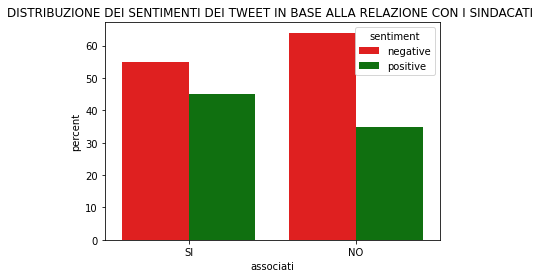

In [145]:
sns.barplot(data=df,x='associati',y='percent',hue='sentiment',palette=['r','g']).set_title('DISTRIBUZIONE DEI SENTIMENTI DEI TWEET IN BASE ALLA RELAZIONE CON I SINDACATI ') 
print()

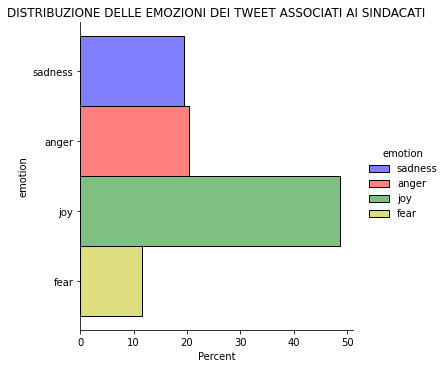

In [142]:
sns.displot(datasent_associati,y='emotion',stat='percent',hue='emotion',palette=['b','r','g','y'])
plt.title('DISTRIBUZIONE DELLE EMOZIONI DEI TWEET ASSOCIATI AI SINDACATI')
print() 

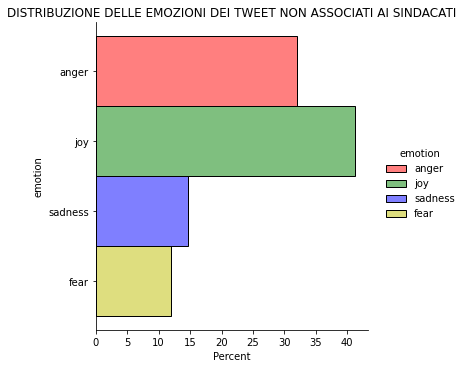

In [144]:
sns.displot(datasent_nonassociati,y='emotion',stat='percent',hue='emotion',palette=['r','g','b','y'])
plt.title('DISTRIBUZIONE DELLE EMOZIONI DEI TWEET NON ASSOCIATI AI SINDACATI') 
print()

In [ ]:
#data.loc[(data['associati']=='SI')].count()#=1249
#data.loc[(data['associati']=='SI') & (data['emotion']=='sadness')].count()#=243
#data.loc[(data['associati']=='SI') & (data['emotion']=='fear')].count()#=144
#data.loc[(data['associati']=='SI') & (data['emotion']=='anger')].count()#=255
#data.loc[(data['associati']=='SI') & (data['emotion']=='joy')].count()#=607
#data.loc[(data['associati']=='NO')].count()#=5194
#data.loc[(data['associati']=='NO') & (data['emotion']=='sadness')].count()#=761
#data.loc[(data['associati']=='NO') & (data['emotion']=='fear')].count()#=625
#data.loc[(data['associati']=='NO') & (data['emotion']=='anger')].count()#=1666
#data.loc[(data['associati']=='NO') & (data['emotion']=='joy')].count()#=2142


In [ ]:
z={'percent':[(243/1249)*100,(144/1249)*100,(255/1249)*100,(607/1249)*100,(761/5194)*100,(625/5194)*100,(1666/5194)*100,(2142/5194)*100],'emotion':['sadness','fear','anger','joy','sadness','fear','anger','joy'],'associati':['SI','SI','SI','SI','NO','NO','NO','NO']}
df1=pd.DataFrame(data=z)
df1



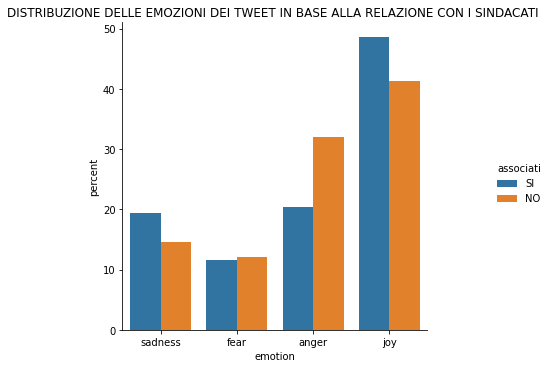

In [226]:
sns.catplot(data=df1,x='emotion',y='percent',hue='associati',kind='bar', dodge=True)
plt.title('DISTRIBUZIONE DELLE EMOZIONI DEI TWEET IN BASE ALLA RELAZIONE CON I SINDACATI ') 
print()

